In [2]:
# Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, make_scorer,r2_score
from scipy.stats import skew
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

# Definitions
pd.set_option('display.float_format', lambda x: '%.3f' % x)
%matplotlib inline
#njobs = 4

In [3]:
# Get train data
train = pd.read_csv("./Data/train.csv")
print("train : " + str(train.shape))

train : (1460, 81)


In [4]:
# Get test data
test = pd.read_csv("./Data/test.csv")
print("test:" + str(test.shape))

test:(1459, 80)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

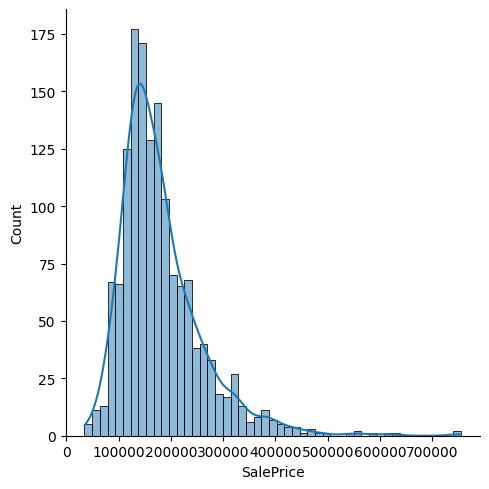

In [5]:
train.info()
train['SalePrice'].describe()
sns.displot(train['SalePrice'],kde=True)

<AxesSubplot:xlabel='GrLivArea', ylabel='SalePrice'>

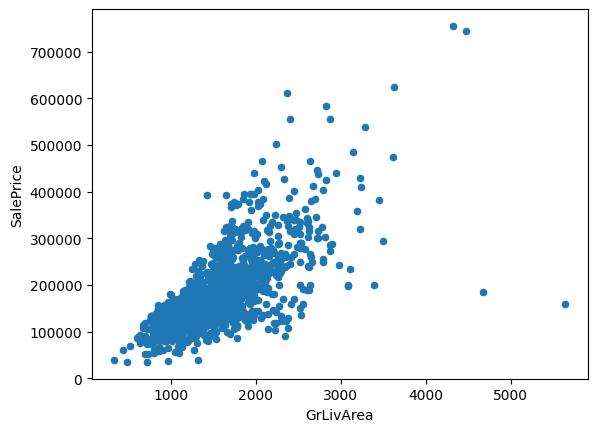

In [6]:
data=pd.concat([train['SalePrice'],train['GrLivArea']],axis=1)
data.plot.scatter(x='GrLivArea',y='SalePrice')

In [7]:
train.loc[(train['SalePrice']<200000) & (train['GrLivArea']>4000)]
train.drop(523,axis=0,inplace=True)
train.drop(1298,axis=0,inplace=True)

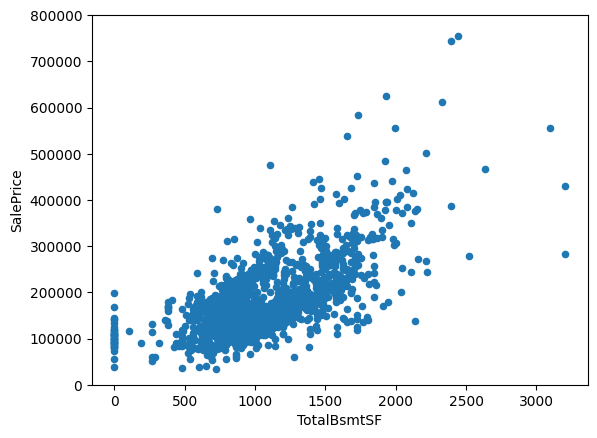

In [8]:
data = pd.concat([train['SalePrice'], train['TotalBsmtSF']], axis=1)
data.plot.scatter(x='TotalBsmtSF', y='SalePrice', ylim=(0,800000));

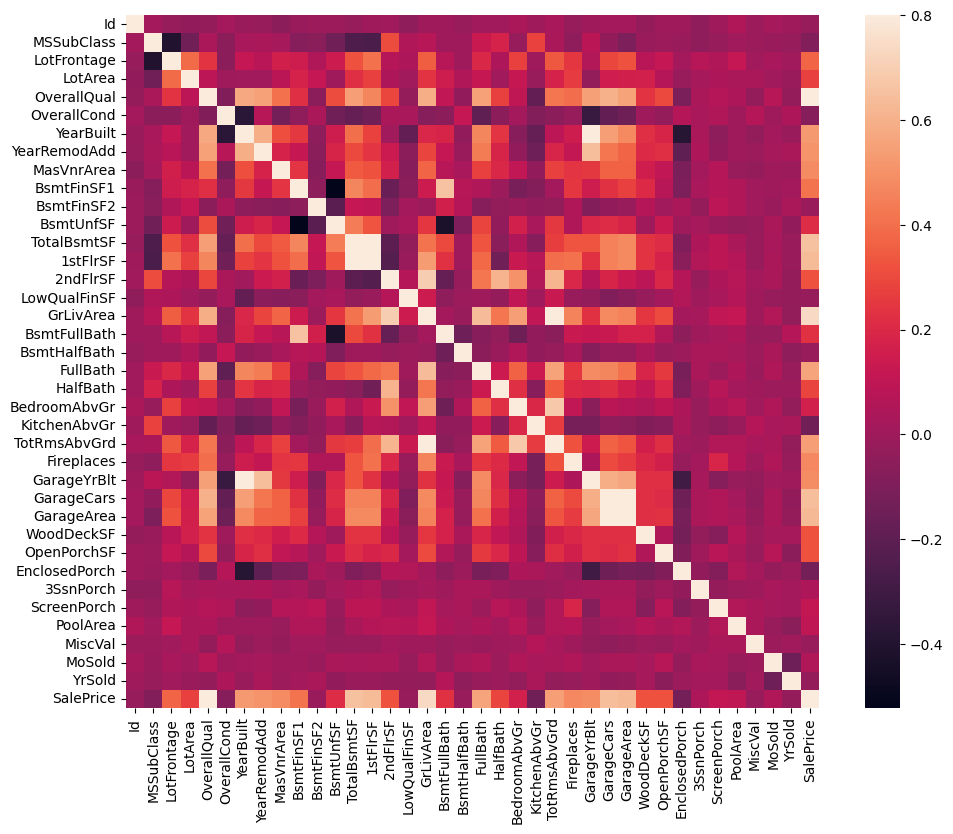

In [9]:
#correlation matrix
corrmat = train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

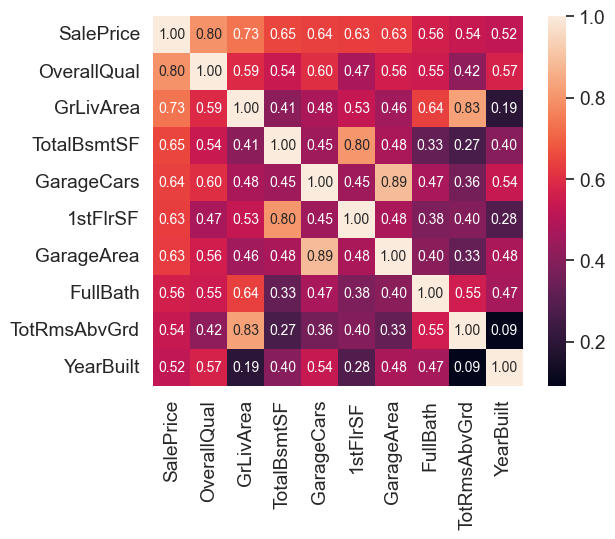

In [10]:
#saleprice correlation matrix
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [11]:
# Missing Data
total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
missing_data=pd.concat([total,percent],axis=1,keys=['Total','Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1452,0.996
MiscFeature,1404,0.963
Alley,1367,0.938
Fence,1177,0.807
FireplaceQu,690,0.473
LotFrontage,259,0.178
GarageYrBlt,81,0.056
GarageCond,81,0.056
GarageType,81,0.056
GarageFinish,81,0.056


In [12]:
#dealing with missing data
train = train.drop((missing_data[missing_data['Total'] > 1]).index,1)
train = train.drop(train.loc[train['Electrical'].isnull()].index)
train.isnull().sum().max() #just checking that there's no missing data missing...

/var/folders/pn/6cn72r6573v911tl8wqc03vc0000gn/T/ipykernel_77330/680243715.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  train = train.drop((missing_data[missing_data['Total'] > 1]).index,1)


0

In [13]:
train.loc[:,['OverallQual','GrLivArea','TotalBsmtSF','GarageCars','1stFlrSF','GarageArea','FullBath','TotRmsAbvGrd','YearBuilt']].head()

,OverallQual,GrLivArea,TotalBsmtSF,GarageCars,1stFlrSF,GarageArea,FullBath,TotRmsAbvGrd,YearBuilt
0,7,1710,856,2,856,548,2,8,2003
1,6,1262,1262,2,1262,460,2,6,1976
2,7,1786,920,2,920,608,2,6,2001
3,7,1717,756,3,961,642,1,7,1915
4,8,2198,1145,3,1145,836,2,9,2000


In [37]:
# Method 1:OLS
ols = LinearRegression(fit_intercept=True)

X_OLS = train.loc[:,['OverallQual','GrLivArea','TotalBsmtSF','GarageCars','1stFlrSF','GarageArea','FullBath','TotRmsAbvGrd','YearBuilt']]
Y_OLS = train.loc[:,'SalePrice']

ols.fit(X_OLS,Y_OLS)

Y_OLS_pred=ols.predict(X_OLS)
r2metrics=r2_score(Y_OLS,Y_OLS_pred)
r2metrics

0.8175609152569898

In [52]:
X_OLS_test=test.loc[:,['OverallQual','GrLivArea','TotalBsmtSF','GarageCars','1stFlrSF','GarageArea','FullBath','TotRmsAbvGrd','YearBuilt']]
X_OLS_test.info()
X_OLS_test=X_OLS_test.astype('int')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   OverallQual   1459 non-null   int64  
 1   GrLivArea     1459 non-null   int64  
 2   TotalBsmtSF   1458 non-null   float64
 3   GarageCars    1458 non-null   float64
 4   1stFlrSF      1459 non-null   int64  
 5   GarageArea    1458 non-null   float64
 6   FullBath      1459 non-null   int64  
 7   TotRmsAbvGrd  1459 non-null   int64  
 8   YearBuilt     1459 non-null   int64  
dtypes: float64(3), int64(6)
memory usage: 102.7 KB


IntCastingNaNError: Cannot convert non-finite values (NA or inf) to integer

In [25]:
total_test=X_OLS_test.isnull().sum().sort_values(ascending=False)
percent_test=(X_OLS_test.isnull().sum()/X_OLS_test.isnull().count()).sort_values(ascending=False)
missingdata_test=pd.concat([total_test,percent_test],axis=1,keys=['Total','Percent'])
missingdata_test.head()

,Total,Percent
TotalBsmtSF,1,0.001
GarageCars,1,0.001
GarageArea,1,0.001
OverallQual,0,0.000
GrLivArea,0,0.000


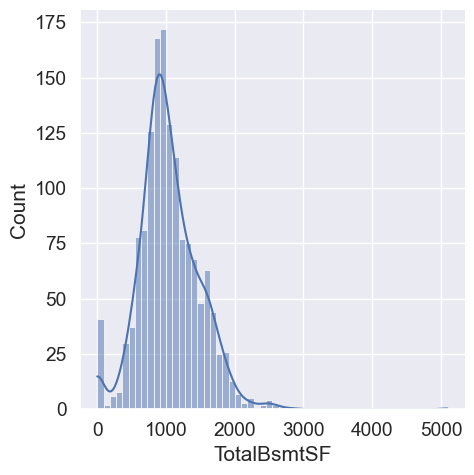

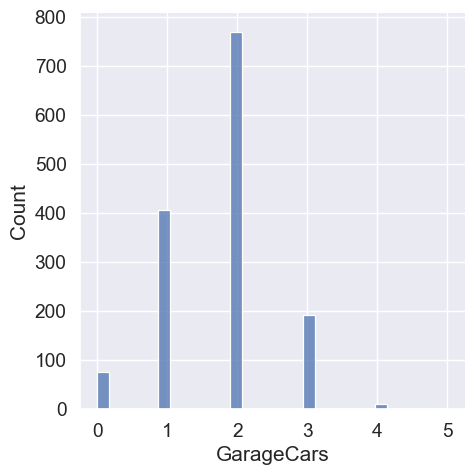

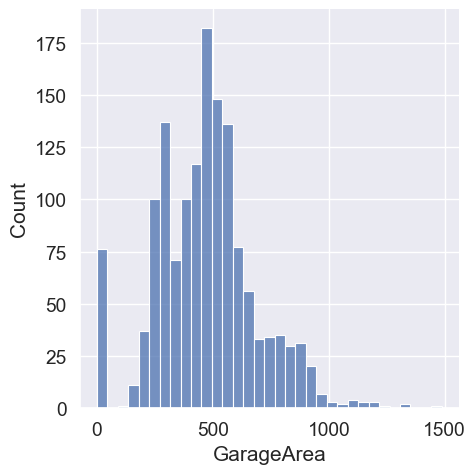

In [27]:
# Histgram for the three columns with missing data
sns.displot(X_OLS_test['TotalBsmtSF'],kde=True)
sns.displot(X_OLS_test['GarageCars'])
sns.displot(X_OLS_test['GarageArea'])


In [49]:
# Fix missing values
X_OLS_test.loc[X_OLS_test['TotalBsmtSF'].isnull(),'TotalBsmtSF']=X_OLS_test['TotalBsmtSF'].median
X_OLS_test.loc[X_OLS_test['GarageCars'].isnull(),'GarageCars']=2
X_OLS_test.loc[X_OLS_test['GarageArea'].isnull(),'GarageArea']=X_OLS_test['GarageArea'].median

X_OLS_test['TotalBsmtSF']=X_OLS_test['TotalBsmtSF'].apply(np.int64)


print(X_OLS_test.info())


TypeError: int() argument must be a string, a bytes-like object or a number, not 'method'

In [40]:
# Linear Model
Y_pred_test = ols.predict(X=X_OLS_test)

TypeError: float() argument must be a string or a number, not 'method'